In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings('ignore')

In [2]:
feature_extraction_algo = 'sift'
feature_to_match = "bf"

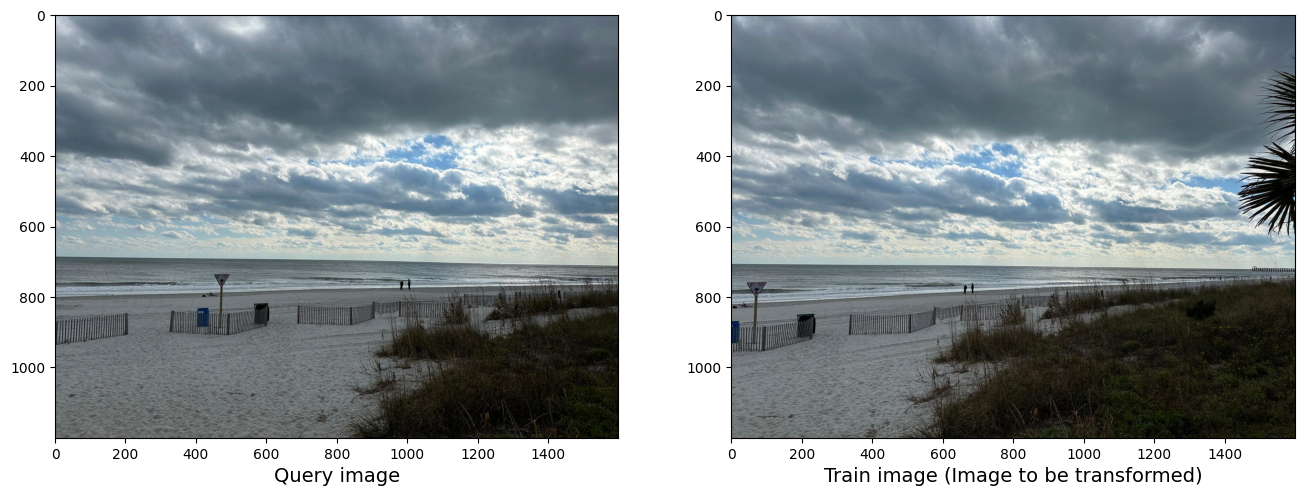

In [3]:
train_photo = cv2.imread('./' + 'ex1.jpg')
train_photo = cv2.cvtColor(train_photo,cv2.COLOR_BGR2RGB)
train_photo_gray = cv2.cvtColor(train_photo,cv2.COLOR_RGB2GRAY)

query_photo = cv2.imread('./' + 'ex2.jpg')
query_photo = cv2.cvtColor(query_photo,cv2.COLOR_BGR2RGB)
query_photo_gray = cv2.cvtColor(query_photo,cv2.COLOR_RGB2GRAY)

fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout = False, figsize=(16,9))
ax1.imshow(query_photo,cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(train_photo,cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.savefig("./_"+'.jpeg', bbox_inches='tight', dpi=300, format='jpeg')

plt.show()

In [4]:
def select_descriptor_methods(image, method=None):
    assert method is not None, "Please define a feature descriptor method. accepted values are: 'Sift','Surf'"

    if method =='sift':
        descriptor = cv2.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()

    (keypoints, features) = descriptor.detectAndCompute(image,None)

    return(keypoints, features)


In [5]:
keypoints_train_img, features_train_img = select_descriptor_methods(train_photo_gray, method = feature_extraction_algo)
keypoints_query_img, features_query_img = select_descriptor_methods(query_photo_gray, method = feature_extraction_algo)


In [6]:
for keypoint in keypoints_query_img:
    x,y = keypoint.pt
    size = keypoint.size
    orientation = keypoint.angle
    response = keypoint.response
    octave = keypoint.octave
    class_id = keypoint.class_id

print(x,y)
print(size)
print(orientation)
print(response)
print(octave)
print(class_id)

1596.4720458984375 722.321533203125
2.334866762161255
89.36651611328125
0.02191285416483879
2294527
-1


In [7]:
print(len(keypoints_query_img))

features_query_img.shape

7920


(7920, 128)

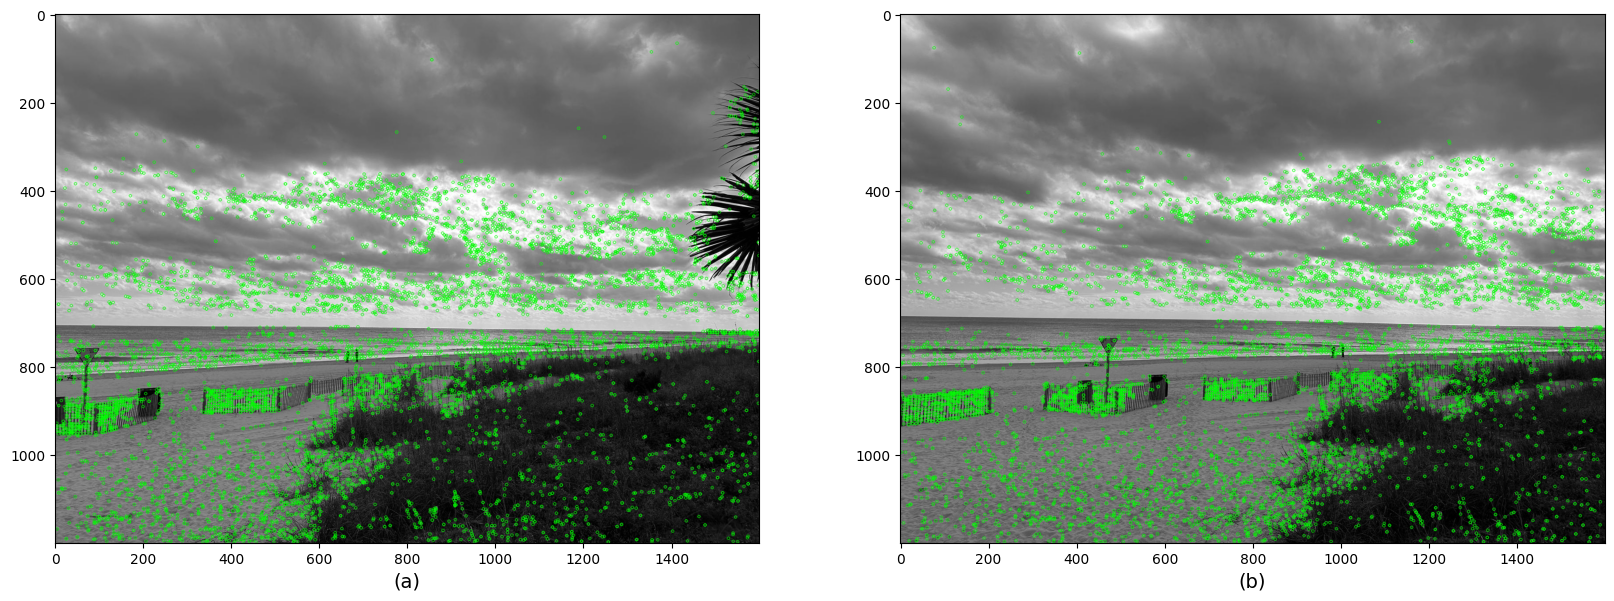

In [8]:
fig,(ax1,ax2) = plt.subplots(nrows =1, ncols=2, figsize=(20,8), constrained_layout=False)

ax1.imshow(cv2.drawKeypoints(train_photo_gray,keypoints_train_img, None, color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize = 14)

ax2.imshow(cv2.drawKeypoints(query_photo_gray,keypoints_query_img, None, color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize = 14)

plt.show()

In [9]:
def create_matching_object(method,crossCheck):
    "Create and return a Matcher Object"

    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck= crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    
    return bf
    

In [10]:
def key_points_matching(features_train_img, features_query_img, method):

    bf = create_matching_object(method, crossCheck=True)

    best_matches = bf.match(features_train_img, features_query_img)

    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches with Brute force):", len(rawMatches))
    return rawMatches

In [11]:
def key_points_matching_KNN(features_train_img,features_query_img,ratio,method):

    bf = create_matching_object(method, crossCheck=False)

    rawMatches = bf.knnMatch(features_train_img,features_query_img, k =2)
    print("Raw matches(knn):",len(rawMatches))
    matches = []

    for m,n in rawMatches:
        if m.distance < n.distance * ratio:
            matches.append(m)
    
    return matches

Drawing: bf matches features Lines
Raw matches with Brute force): 3181


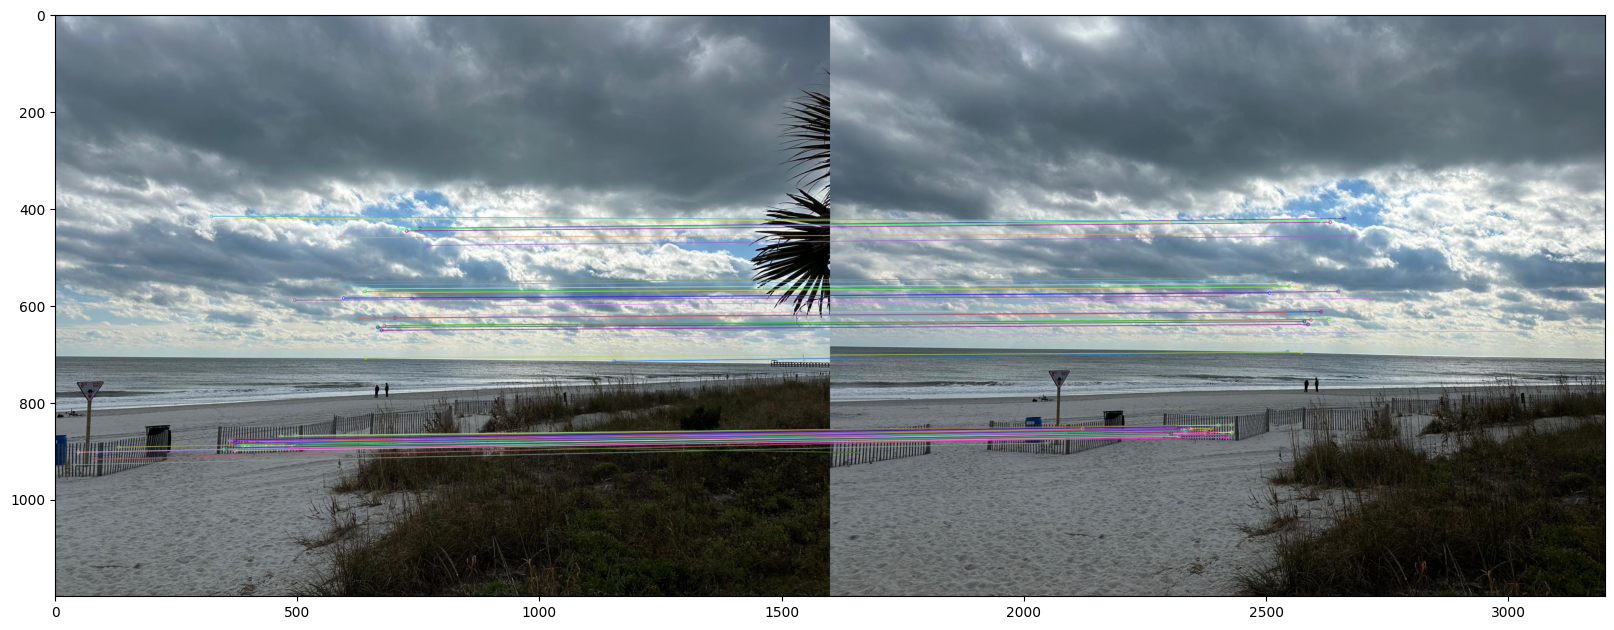

In [12]:
print("Drawing: {} matches features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(features_train_img, features_query_img ,method = feature_extraction_algo)

    mapped_features_image = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, matches[:100],None,flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(features_train_img, features_query_img ,ratio = 0.75,method = feature_extraction_algo)

    mapped_features_image_knn = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, matches[:100],None,flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_features_image)

Drawing: knn matches features Lines
Raw matches(knn): 7726


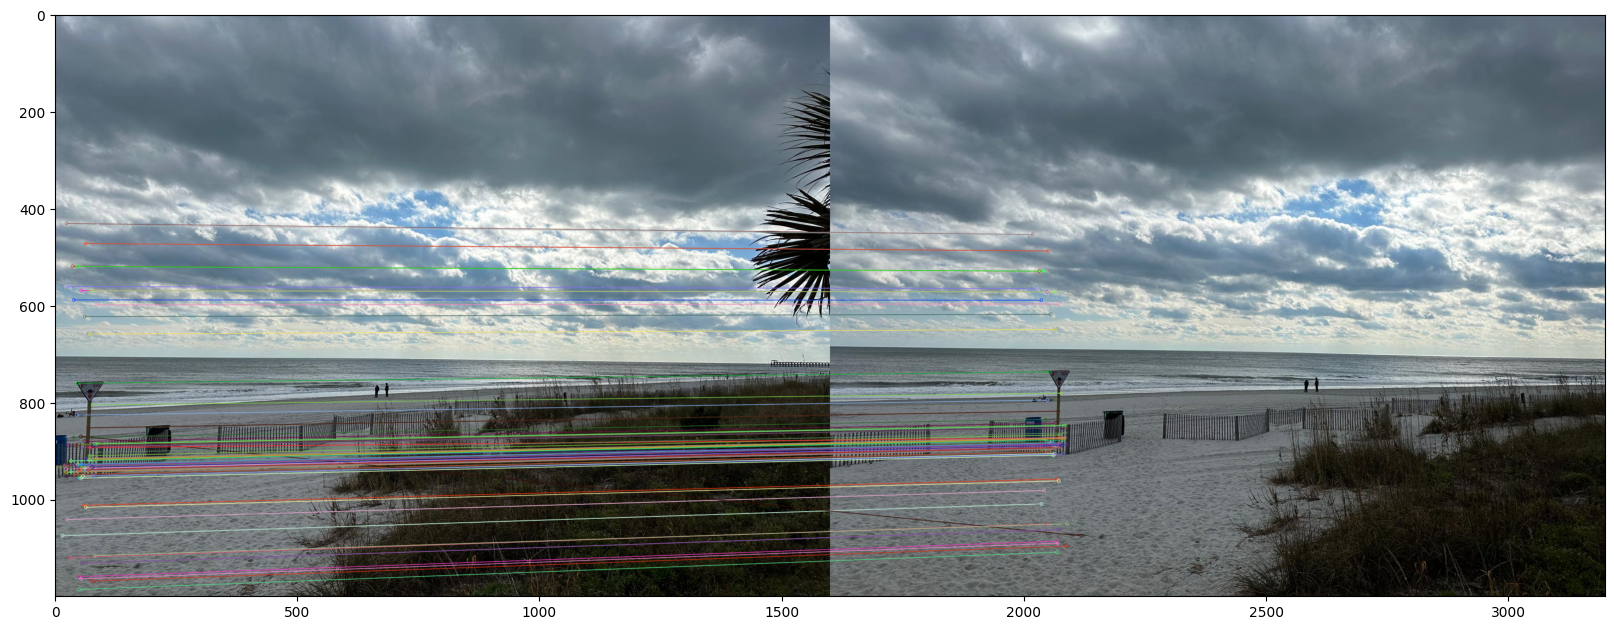

In [13]:
feature_to_match = 'knn'

print("Drawing: {} matches features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(features_train_img, features_query_img ,method = feature_extraction_algo)

    mapped_features_image = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, matches[:100],None,flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(features_train_img, features_query_img ,ratio = 0.75,method = feature_extraction_algo)

    mapped_features_image_knn = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, matches[:100],None,flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_features_image_knn)

In [14]:
def homography_stitching(keypoints_train_img,keypoints_query_img,matches, reprojThresh):

    keypoints_train_img = np.float32([keypoint.pt for keypoint in keypoints_train_img])
    keypoints_query_img = np.float32([keypoint.pt for keypoint in keypoints_query_img])

    if len(matches) > 4:
        points_train = np.float32([keypoints_train_img[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_img[m.trainIdx] for m in matches])

        (H,status) = cv2.findHomography(points_train,points_query,cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

In [15]:
M = homography_stitching(keypoints_train_img, keypoints_query_img, matches ,reprojThresh= 4)

if M is None:
    print("Error!")

(matches, Homography_Matrix, status) = M

print(Homography_Matrix)

[[ 6.28513460e-01  4.06009369e-02  3.86260472e+02]
 [-1.53814741e-01  8.48173713e-01  9.00111355e+01]
 [-2.30738632e-04 -1.91585689e-06  1.00000000e+00]]


width 3200


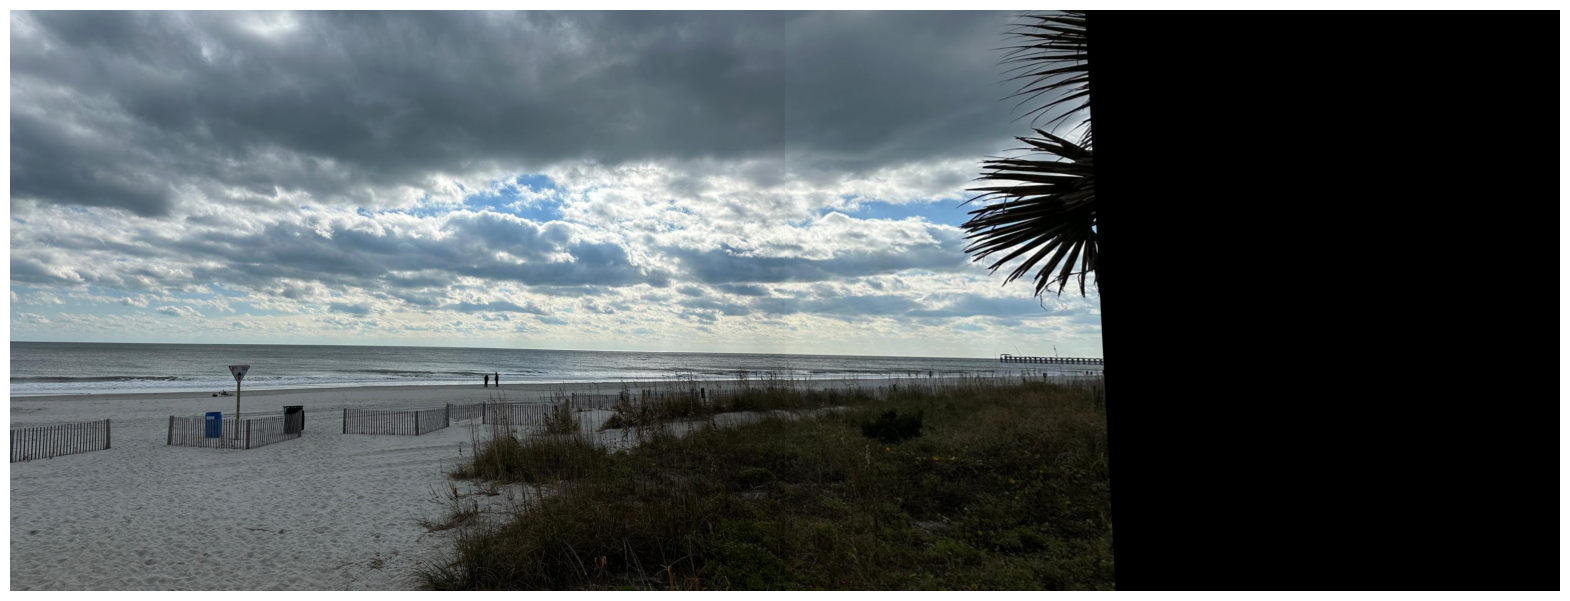

In [16]:
width = query_photo.shape[1] + train_photo.shape[1]
print("width", width)

height = max(query_photo.shape[0], train_photo.shape[0])

result = cv2.warpPerspective(train_photo,Homography_Matrix,(width,height))

result[0:query_photo.shape[0], 0:query_photo.shape[1]] = query_photo

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(result)

plt.show()